![Logo das Instituições](logos_instituicoes_colorido.png)

<h1 style="text-align:center; font-weight:bold;">Abordagem Baseada em Aprendizado de Máquina para o Diagnóstico de Doenças Eritemato-Escamosas</h1>

---

## Descrição do Projeto

Este notebook é o projeto final da disciplina Aprendizado de Máquina, cursada no segundo semestre do Bacharelado em Ciência e Tecnologia da Ilum Escola de Ciência. O objetivo dessa aplicação é aplicar e aprofundar os conhecimentos adquiridos ao longo do semestre em um projeto prático, apresentado em uma reunião com o professor responsável pela disciplina.

## Índice

1. [Introdução](#1-introdução)

2. [Informações do Conjunto de Dados](#2-informações-do-conjunto-de-dados)  

3. [Coleta de Dados](#3-coleta-de-dados)  

4. [Tratamento de Dados](#4-tratamento-de-dados)  

5. [Divisão Treino e Teste](#5-divisão-treino-e-teste) 

6. [Modelo *Baseline*](#6-modelo-baseline)  
   - [6.1. Criação do Modelo](#61-criação-do-modelo)  
   - [6.2. Avaliação do Modelo](#62-avaliação-do-modelo)  

7. [Modelo *K-Neighbors Classifier*](#7-modelo-kneighborsclassifier)  
   - [7.1. Criação do Modelo](#71-criação-do-modelo)  
   - [7.2. Otimização](#72-otimização)    
   - [7.3. Avaliação do Modelo](#73-avaliação-do-modelo)  

8. [Modelo *Voting Feature Intervals*](#8-modelo-voting-feature-intervals)  
   - [8.1. Criação do Modelo](#81-criação-do-modelo)   
   - [8.2. Otimização](#82-otimização)  
   - [8.3. Avaliação do Modelo](#83-avaliação-do-modelo)  

9. [Conclusão](#9-conclusão)  

10. [Contribuidores](#10-contribuidores)  

11. [Professor Responsável](#12-professor-responsável)

12. [Referências](#13-referências)


## 1. Introdução <a id="introducao"></a>

O diagnóstico diferencial das doenças eritemato-escamosas é um desafio na dermatologia, pois esse grupo de enfermidades compartilham características clínicas e histopatológicas muito semelhantes, como eritema e descamação. Essa semelhança dificulta a distinção entre elas, mesmo com o uso de biópsias.

Neste projeto, propomos uma abordagem de aprendizado de máquina para auxiliar nesse diagnóstico, utilizando o dataset *Dermatology* (ILTER; GÜVENIR, 1998) do *UCI Machine Learning Repository*. Foram aplicados três modelos de classificação: um modelo *baseline*, o *K-Neighbors Classifier* (KNN) — aprendido durante o curso — e o *Voting Feature Intervals* (VFI), modelo de referência na literatura para esse problema.

Após a otimização e avaliação de cada modelo, com base em métricas de desempenho apresentadas em relatórios de classificação, buscamos identificar o algoritmo com melhor capacidade preditiva, demonstrando o potencial do aprendizado de máquina como ferramenta de apoio ao diagnóstico médico.

## 2. Informações do Dataset

O dataset *Dermatology* (ILTER; GÜVENIR, 1998) foi desenvolvido para apoiar estudos sobre o diagnóstico diferencial de doenças eritemato-escamosas, reunindo informações clínicas e histopatológicas de pacientes com $6$ diferentes condições dermatológicas (**psoríase**, **dermatite seborreica**, **líquen plano**, **pitiríase rósea**, **dermatite crônica** e **pitiríase rubra pilar**).

O objetivo do conjunto de dados é identificar a doença de cada paciente, que constitui o *target*. No dataset, essas seis doenças foram codificadas numericamente de $1$ a $6$, sendo: 

- $1$: Psoríase
- $2$: Dermatite Seborreica
- $3$: Líquen Plano
- $4$: Pitiríase Rósea
- $5$: Dermatite Crônica
- $6$: Pitiríase Rubra Pilar

O banco de dados é multivariado, composto por $366$ instâncias e $34$ atributos, dos quais $33$ são de dados qunatitativos discretos e $1$ é qualitativo nominal.

Os pacientes foram inicialmente avaliados clinicamente, com base em $12$ características observáveis, como eritema, descamação e espessamento da pele. Em seguida, foram analisadas $22$ características histopatológicas, obtidas a partir de amostras de pele examinadas ao microscópio.

As variáveis histopatológicas e clínicas foram quantificadas em uma escala ordinal de $0$ a $3$, na qual:

- $0$ indica ausência da característica;
- $1$ e $2$ representam graus intermediários;
- $3$ indica o grau máximo de manifestação.

Além disso, o atributo história familiar assume o valor $1$ quando há registro da doença em familiares e $0$ caso contrário. O atributo idade representa a idade do paciente.

Os nomes e identificações pessoais foram removidos do conjunto de dados para preservar a privacidade dos participantes.


## 3. Coleta de Dados

Importa-se o dataset *Dermatology* do *UCI Machine Learning Repository* usando a biblioteca `ucimlrepo`.
As variáveis são divididas em:

- `X`: atributos;

- `y`: target (diagnóstico).

In [28]:
from ucimlrepo import fetch_ucirepo 

dermatology = fetch_ucirepo(id=33) 
  
X = dermatology.data.features 
y = dermatology.data.targets['class']
  
# Informação das variáveis
print(dermatology.variables) 

                                           name     role     type demographic  \
0                                      erythema  Feature  Integer        None   
1                                       scaling  Feature  Integer        None   
2                              definite-borders  Feature  Integer        None   
3                                       itching  Feature  Integer        None   
4                            koebner phenomenon  Feature  Integer        None   
5                             polygonal papules  Feature  Integer        None   
6                            follicular papules  Feature  Integer        None   
7                      oral-mucosal involvement  Feature  Integer        None   
8                        knee elbow involvement  Feature  Integer        None   
9                             scalp involvement  Feature  Integer        None   
10                               family history  Feature   Binary        None   
11                         m

## 4. Tratamento de Dados

Utiliza-se o `KNNImputer` para preencher valores ausentes, substituindo-os com base nos valores médios dos vizinhos mais próximos (no caso, $5$ vizinhos), preservando a coerência das amostras sem distorcer a distribuição original dos dados.

Após a imputação, os dados são organizados novamente em um DataFrame do `pandas`, mantendo os nomes das colunas originais.

In [2]:
from sklearn.impute import KNNImputer
import pandas as pd 

imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


## 5. Divisão Treino e Teste

Nesta etapa, o conjunto de dados é dividido em duas partes:

- Treino ($90\%$): usado para ajustar os modelos e encontrar os melhores parâmetros;

- Teste ($10\%$): usado para avaliar o desempenho dos modelos em dados nunca vistos.

A divisão é feita com a função `train_test_split`, utilizando uma semente aleatória fixa (`SEMENTE_ALEATORIA = 42`) para garantir reprodutibilidade dos resultados.

In [3]:
from sklearn.model_selection import train_test_split

SEMENTE_ALEATORIA = 42
TAMANHO_TESTE = 0.1

X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

A variável `ordem_labels` é criada para armazenar a ordem das classes do *target*, o que será útil na geração dos relatórios de classificação e na interpretação dos resultados.

In [4]:
ordem_labels = sorted(y.unique())

## 6. Modelo *Baseline*

Antes de aplicar modelos mais complexos, é importante estabelecer um modelo de referência (*baseline*). Esse modelo serve como um ponto de comparação, permitindo avaliar se os classificadores mais sofisticados realmente trazem ganhos de desempenho.

Aqui, utilizamos o `DummyClassifier`, que realiza previsões simples (como sempre escolher a classe mais frequente). Embora seja um modelo sem aprendizado real, ele fornece uma linha de base mínima para avaliar a eficácia dos demais algoritmos.

### 6.1. Criação do Modelo

Nesta etapa, o modelo *baseline* `DummyClassifier` é treinado com os dados de treino (`X_treino` e `y_treino`), aprendendo apenas a frequência das classes, sem considerar os atributos do conjunto.

In [5]:
from sklearn.dummy import DummyClassifier

modelo_baseline = DummyClassifier()

modelo_baseline.fit(X_treino, y_treino)

,strategy,'prior'
,random_state,None
,constant,None


### 6.2. Avaliação do Modelo

Para avaliar o desempenho do modelo *baseline*, utilizamos duas ferramentas principais:

- **Matriz de confusão**: mostra o número de acertos e erros em cada classe, facilitando a visualização do padrão de previsões incorretas.

- **Relatório de classificação**: apresenta métricas como *precision*, *recall* e *f1-score* para cada classe.

Essas métricas permitirão comparar, nas próximas seções, o quanto os modelos mais complexos de aprendizado de máquina superam o desempenho desse modelo referência.

**Matriz de Confusão**

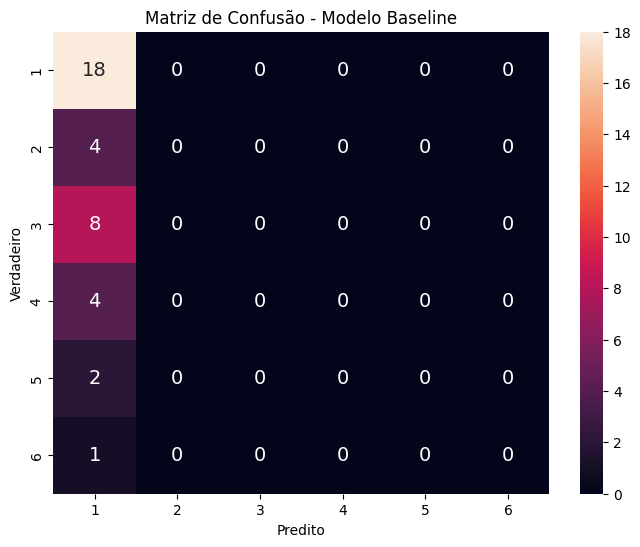

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_verdadeiro = y_teste
y_previsao = modelo_baseline.predict(X_teste)

matriz_conf = confusion_matrix(y_verdadeiro, y_previsao, labels=ordem_labels)
df_conf = pd.DataFrame(matriz_conf, ordem_labels, ordem_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(df_conf, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - Modelo Baseline")
plt.show()

**Relatório de Classificação**

In [31]:
from sklearn.metrics import classification_report

print("Relatório de Classificação - Modelo Baseline")
print()
print(classification_report(y_teste, y_previsao, target_names=[str(c) for c in ordem_labels], zero_division=0))

Relatório de Classificação - Modelo Baseline

              precision    recall  f1-score   support

           1       0.49      1.00      0.65        18
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1

    accuracy                           0.49        37
   macro avg       0.08      0.17      0.11        37
weighted avg       0.24      0.49      0.32        37



## 7. Modelo *K-Neighbors Classifier*

O algoritmo *K-Nearest Neighbors* (KNN) é um dos classificadores mais intuitivos e foi estudado ao longo da disciplina. Ele classifica uma amostra com base nos rótulos das amostras mais próximas no espaço de atributos, medindo a similaridade por meio de distâncias.

Nesta seção, aplicamos, otimizamos e avaliamos o KNN, explorando diferentes combinações de parâmetros para alcançar o melhor desempenho.

### 7.1. Criação do Modelo

Nesta parte, é definida uma função de criação do modelo (`cria_modelo`) para ser usada na otimização com o `optuna`.
A função permite ajustar automaticamente parâmetros importantes do KNN, como:

- `n_neighbors`: número de vizinhos considerados;

- `weights`: tipo de ponderação das distâncias;

- `p`: tipo de métrica de distância ($1$: Manhattan, $2$: Euclidiana).

Também são testadas duas opções de pré-processamento:

- Normalização dos dados (`StandardScaler`), para evitar que atributos em escalas diferentes influenciem o cálculo das distâncias;

- Redução de dimensionalidade com PCA, que pode melhorar o desempenho e reduzir ruído.

O modelo é estruturado em um *pipeline*, que combina essas etapas conforme definido pelos parâmetros escolhidos.

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

def cria_modelo(trial):
    """Cria instância do KNN com opções de normalização e PCA (para Optuna)."""
    
    parametros = {
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 50),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "p": trial.suggest_float("p", 1, 2),
        "n_jobs": -1,
    }
    
    normalizar = trial.suggest_categorical("normalizar", [True, False])
    usar_pca = trial.suggest_categorical("usar_pca", [True, False])
    
    # Se PCA for usado, define número de componentes
    if usar_pca:
        num_componentes = trial.suggest_int("n_componentes", 1, min(X_treino.shape[1], 20))
    else:
        num_componentes = None
    
    # Monta pipeline dinamicamente
    etapas = []
    if normalizar:
        etapas.append(("scaler", StandardScaler()))
    if usar_pca:
        etapas.append(("pca", PCA(n_components=num_componentes)))
    etapas.append(("knn", KNeighborsClassifier(**parametros)))
    
    modelo = make_pipeline(*[etapa[1] for etapa in etapas])
    
    return modelo

### 7.2. Otimização

Aqui, aplicamos o `optuna`, uma biblioteca feita para otimização de hiperparâmetros.

A função `otimizar_knn` realiza um processo iterativo de busca, avaliando múltiplas combinações de parâmetros do KNN com validação cruzada estratificada ($5$ *folds*).

O objetivo é maximizar a acurácia média, garantindo que o modelo final seja o mais eficiente possível.

Após o estudo, o notebook exibe os melhores parâmetros encontrados, que são então utilizados para reconstruir e treinar o modelo final otimizado (`modelo_knn_otimizado`).

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import optuna

def otimizar_knn(X, y, n_trials=30):
    """Usa Optuna para encontrar os melhores hiperparâmetros do KNN."""
    
    def objetivo(trial):
        modelo = cria_modelo(trial)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEMENTE_ALEATORIA)
        scores = cross_val_score(modelo, X, y, cv=cv, scoring="accuracy")
        return scores.mean()
    
    estudo = optuna.create_study(direction="maximize")
    estudo.optimize(objetivo, n_trials=n_trials)
    
    print("Melhores parâmetros:", estudo.best_params)
    
    return estudo.best_params

melhores_params = otimizar_knn(X_treino, y_treino, n_trials=30)

[I 2025-10-27 15:23:13,719] A new study created in memory with name: no-name-49cf6eab-6986-400b-9168-60991b56438d
[I 2025-10-27 15:23:13,921] Trial 0 finished with value: 0.9026107226107225 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'p': 1.8037642868726877, 'normalizar': True, 'usar_pca': False}. Best is trial 0 with value: 0.9026107226107225.
[I 2025-10-27 15:23:14,084] Trial 1 finished with value: 0.9543589743589743 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 1.3841806158823011, 'normalizar': True, 'usar_pca': False}. Best is trial 1 with value: 0.9543589743589743.
[I 2025-10-27 15:23:14,312] Trial 2 finished with value: 0.8236829836829838 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'p': 1.570887238854732, 'normalizar': False, 'usar_pca': False}. Best is trial 1 with value: 0.9543589743589743.
[I 2025-10-27 15:23:14,531] Trial 3 finished with value: 0.8996270396270397 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'p': 1.15

Melhor acurácia média: 0.9695104895104896
Melhores parâmetros: {'n_neighbors': 6, 'weights': 'distance', 'p': 1.7904625927831537, 'normalizar': True, 'usar_pca': False}


**Reconstrói o modelo final com os melhores parâmetros**

In [13]:
# Lê os parâmetros do estudo
p = melhores_params["p"]
n_neighbors = melhores_params["n_neighbors"]
weights = melhores_params["weights"]
normalizar = melhores_params["normalizar"]
usar_pca = melhores_params["usar_pca"]
num_componentes = melhores_params.get("n_componentes", None)

# Monta pipeline final
etapas_finais = []
if normalizar:
    etapas_finais.append(("scaler", StandardScaler()))
if usar_pca and num_componentes is not None:
    etapas_finais.append(("pca", PCA(n_components=num_componentes)))
etapas_finais.append(("knn", KNeighborsClassifier(
    n_neighbors=n_neighbors,
    weights=weights,
    p=p,
    n_jobs=-1
)))

modelo_knn_otimizado = make_pipeline(*[e[1] for e in etapas_finais])
modelo_knn_otimizado.fit(X_treino, y_treino)

,steps,"[('standardscaler', ...), ('kneighborsclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,6
,weights,'distance'
,algorithm,'auto'
,leaf_size,30


### 7.3. Avaliação do Modelo

Após o treinamento do modelo otimizado, avaliamos seu desempenho:

**Matriz de Confusão**

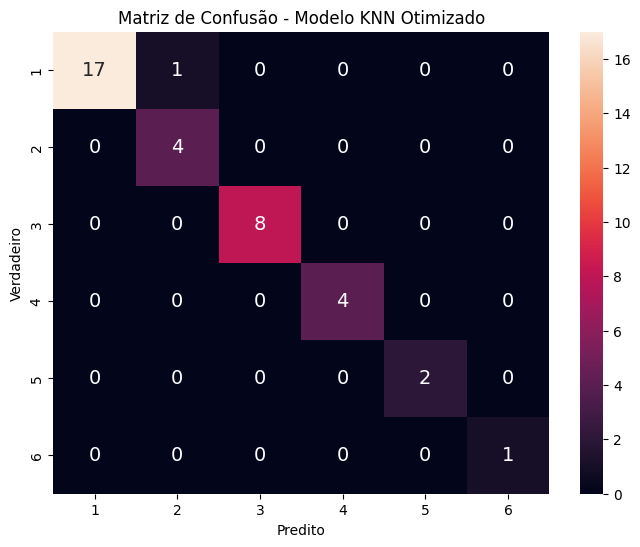

In [32]:
y_pred = modelo_knn_otimizado.predict(X_teste)

ordem_labels = sorted(y.unique())
matriz_conf = confusion_matrix(y_teste, y_pred, labels=ordem_labels)
df_conf = pd.DataFrame(matriz_conf, index=ordem_labels, columns=ordem_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(df_conf, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - Modelo KNN Otimizado")
plt.show()

**Relatório de Classificação**

In [34]:
print("Relatório de Classificação - Modelo KNN Otimizado")
print()
print(classification_report(y_teste, y_pred, target_names=[str(c) for c in ordem_labels]))

Relatório de Classificação - Modelo KNN Otimizado

              precision    recall  f1-score   support

           1       1.00      0.94      0.97        18
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1

    accuracy                           0.97        37
   macro avg       0.97      0.99      0.98        37
weighted avg       0.98      0.97      0.97        37



## 8. Modelo *Voting Feature Intervals*

O modelo *Voting Feature Intervals* (VFI5) é um algoritmo de classificação supervisionada que funciona com base na ideia de que, para cada classe do *target* e para cada atributo, é possível definir um intervalo de valores representativos observados nos dados de treinamento.

Ao classificar uma nova amostra:

**1°** Cada atributo verifica em quais intervalos de classe seu valor se encaixa.  
**2°** Cada encaixe “vota” na classe correspondente.  
**3°** A classe com mais votos é escolhida como previsão final.  
**4°** Em caso de empate, critérios adicionais como distância ao centro do intervalo da classe ou KNN local podem ser usados para desempatar.

**Exemplo Prático**
> 
>  
> Suponha um problema de diagnóstico médico com duas classes: $A$ (saudável) e $B$ (disfunção metabólica), e dois atributos: `Glicose` e `Pressão`.
>
> | Paciente | Glicose | Pressão | Classe   |
> | -------- | ------- | ------- | -------- |
> | $P1$     | $85$    | $120$   | $A$      |
> | $P2$     | $90$    | $110$   | $A$      |
> | $P3$     | $88$    | $125$   | $A$      |
> | $P4$     | $150$   | $140$   | $B$      |
> | $P5$     | $160$   | $130$   | $B$      |
> | $P6$     | $155$   | $145$   | $B$      |
>
> *Intervalos calculados pelo VFI5:*
>
> | Classe | Glicose     | Pressão     |
> | ------ | ----------- | ----------- |
> | $A$    | [85, 90]    | [110,125]   |
> | $B$    | [150,160]   | [130,145]   |
>
> *Classificação de um novo paciente:*
>
> * Valores: 
>   - `Glicose` = 89
>   - `Pressão` = 140
>
> * Votos:
>   * `Glicose`: pertence a $A$ → $A$ recebe 1 voto
>   * `Pressão`: pertence a $B$ → $B$ recebe 1 voto
>
> * Empate: desempate pela distância ao centro dos intervalos → resultado: **Classe A (saudável)**  
>  $\quad$

**Observação**: parte do código do VFI que será apresentado foi desenvolvida com auxílio de Inteligência Artificial, uma vez que envolve conceitos de Programação Orientada a Objetos (POO), como a criação de classes, que ainda não foram formalmente apresentados no curso.

### 8.1. Criação do Modelo

Nesta etapa, implementamos o modelo *Voting Feature Intervals* (VFI5) em Python.
O código define:

- Uma função de ajuste (`vfi5`) que constrói intervalos e distribuições de votos;

- Uma função de predição (`vfi5_predict`) que realiza a votação entre classes;

- Uma classe compatível com o `scikit-learn` (`VFIClassifier`), herdando de `BaseEstimator` e `ClassifierMixin`.

Essas duas classes do `sklearn` são interfaces base que padronizam o comportamento de modelos personalizados, permitindo que o VFI seja usado com funções como `fit()`, `predict()`, `cross_val_score()` e `optuna` para otimização.

In [ ]:
from collections import defaultdict
import numpy as np

def vfi5(X: pd.DataFrame, y: pd.Series, num_intervalos=5, suavizacao=0.0):
    classes = np.unique(y)
    atributos = X.columns
    contagem_classes = y.value_counts().to_dict()

    intervalos = {}
    votos_por_intervalo = {}

    for atributo in atributos:
        intervalos[atributo] = []

        if np.issubdtype(X[atributo].dtype, np.number):
            # Criar intervalos numéricos igualmente espaçados
            valor_min, valor_max = X[atributo].min(), X[atributo].max()
            limites = np.linspace(valor_min, valor_max, num_intervalos + 1)
            intervalos[atributo] = [(limites[i], limites[i+1]) for i in range(len(limites)-1)]
        else:
            valores_unicos = X[atributo].unique()
            intervalos[atributo] = [(v, v) for v in valores_unicos]

        votos_por_intervalo[atributo] = defaultdict(lambda: defaultdict(float))

        # Contar instâncias por intervalo e classe
        for i, (baixo, alto) in enumerate(intervalos[atributo]):
            for classe in classes:
                if np.issubdtype(X[atributo].dtype, np.number):
                    mascara = (X[atributo] >= baixo) & (X[atributo] < alto)
                else:
                    mascara = X[atributo] == baixo
                contagem = np.sum(mascara & (y == classe)) + suavizacao  # suavização
                votos_por_intervalo[atributo][i][classe] = contagem / (contagem_classes[classe] + suavizacao * len(intervalos[atributo]))

        # Normalizar votos
        for i in votos_por_intervalo[atributo]:
            total = sum(votos_por_intervalo[atributo][i].values())
            if total > 0:
                for classe in classes:
                    votos_por_intervalo[atributo][i][classe] /= total

    return intervalos, votos_por_intervalo, classes, atributos

**Função de Predição**

In [35]:
def vfi5_predict(X: pd.DataFrame, intervalos, votos_por_intervalos, classes, atributos, pesos_atributos=None):
    previsoes = []
    if pesos_atributos is None:
        pesos_atributos = {atributo: 1.0 for atributo in atributos}

    for _, linha in X.iterrows():
        votos_classe = defaultdict(float)

        for atributo in atributos:
            valor = linha[atributo]
            for i, (baixo, alto) in enumerate(intervalos[atributo]):
                if np.issubdtype(type(valor), np.number):
                    if baixo <= valor < alto:
                        for classe in classes:
                            votos_classe[classe] += votos_por_intervalos[atributo][i][classe] * pesos_atributos[atributo]
                        break
                else:
                    if valor == baixo:
                        for classe in classes:
                            votos_classe[classe] += votos_por_intervalos[atributo][i][classe] * pesos_atributos[atributo]
                        break
        previsoes.append(max(votos_classe, key=votos_classe.get))
    return np.array(previsoes)
                    

**Classe Compatível com `sklearn`**

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class VFIClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_intervalos=5, suavizacao=0.0):
        self.num_intervalos = num_intervalos
        self.suavizacao = suavizacao

    def fit(self, X, y):
        self.intervalos, self.votos, self.classes, self.atributos = vfi5(
            X, y, num_intervalos=self.num_intervalos, suavizacao=self.suavizacao)
        return self

    def predict(self, X):
        return vfi5_predict(X, self.intervalos, self.votos, self.classes, self.atributos)

### 8.2. Otimização

O modelo é otimizado com `optuna`, buscando os melhores valores para:

- `num_intervalos`: número de divisões em cada atributo;

- `suavizacao`: fator que evita contagens nulas.

A otimização é feita com validação cruzada estratificada ($5$ *folds*), maximizando a acurácia média.

Os melhores parâmetros são exibidos e usados para treinar o modelo final.

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import optuna

def otimizar_vfi(X, y, n_trials=50):
    def objetivo(trial):
        num_intervalos = trial.suggest_int('num_intervalos', 2, 20)
        suavizacao = trial.suggest_float('suavizacao', 0.0, 1.0)

        modelo = VFIClassifier(num_intervalos=num_intervalos, suavizacao=suavizacao)
        validacao_cruzada = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEMENTE_ALEATORIA)
        pontuacoes = cross_val_score(modelo, X, y, cv=validacao_cruzada, scoring='accuracy')
        return pontuacoes.mean()

    estudo = optuna.create_study(direction='maximize')
    estudo.optimize(objetivo, n_trials=n_trials)

    print("Melhor resultado:", estudo.best_value)
    print("Melhores hiperparâmetros:", estudo.best_params)
    return estudo.best_params

melhores_params = otimizar_vfi(X_treino, y_treino, n_trials=30)

[I 2025-10-27 09:04:52,542] A new study created in memory with name: no-name-20d5ae99-b82b-41ef-8b9a-34b3efa6ee4a
[I 2025-10-27 09:04:53,228] Trial 0 finished with value: 0.8934265734265734 and parameters: {'num_intervalos': 2, 'suavizacao': 0.05556120030335543}. Best is trial 0 with value: 0.8934265734265734.
[I 2025-10-27 09:04:56,664] Trial 1 finished with value: 0.9513286713286714 and parameters: {'num_intervalos': 16, 'suavizacao': 0.9761019551267245}. Best is trial 1 with value: 0.9513286713286714.
[I 2025-10-27 09:04:57,213] Trial 2 finished with value: 0.8934265734265734 and parameters: {'num_intervalos': 2, 'suavizacao': 0.13191564903506248}. Best is trial 1 with value: 0.9513286713286714.
[I 2025-10-27 09:04:59,798] Trial 3 finished with value: 0.9604195804195804 and parameters: {'num_intervalos': 13, 'suavizacao': 0.21135812849499735}. Best is trial 3 with value: 0.9604195804195804.
[I 2025-10-27 09:05:03,922] Trial 4 finished with value: 0.9513286713286714 and parameters: {

Melhor resultado: 0.9695104895104896
Melhores hiperparâmetros: {'num_intervalos': 10, 'suavizacao': 0.43355444172881186}


### 8.3. Avaliação do Modelo

Após o treinamento do modelo otimizado, avaliamos seu desempenho:

In [38]:
modelo_vfi = VFIClassifier(**melhores_params)
modelo_vfi.fit(X_treino, y_treino)

y_pred = modelo_vfi.predict(X_teste)

**Matriz Confusão**

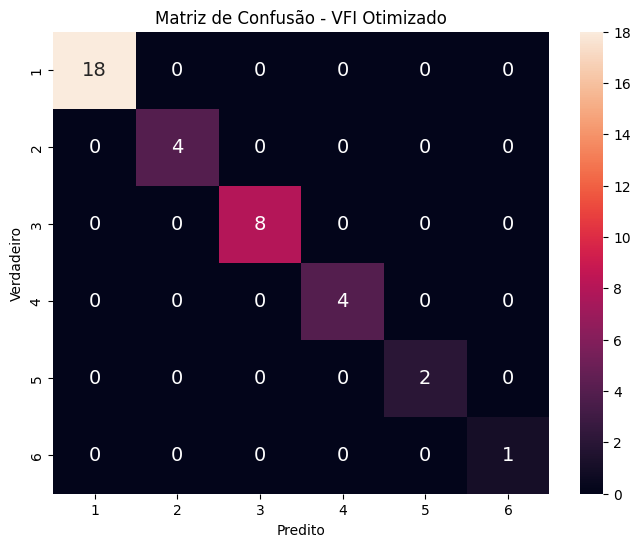

In [39]:
ordem_labels = sorted(y.unique())
matriz_conf = confusion_matrix(y_teste, y_pred, labels=ordem_labels)

df_conf = pd.DataFrame(matriz_conf, index=ordem_labels, columns=ordem_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(df_conf, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - VFI Otimizado")
plt.show()

**Relatório de Classificação**

In [40]:
print(classification_report(y_teste, y_pred, target_names=[str(c) for c in ordem_labels]))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



## 9. Conclusão

Neste projeto, avaliamos três abordagens para o diagnóstico de doenças eritemato-escamosas utilizando aprendizado de máquina:

- Modelo *Baseline*: apresentou desempenho limitado, com acurácia de $49\%$. Este resultado evidencia que apenas a distribuição de classes não é suficiente para prever corretamente as doenças, servindo como referência mínima.

- Modelo *KNeighborsClassifier* (KNN): mostrou melhoria significativa, alcançando $97\%$ de acurácia. O modelo foi capaz de capturar relações entre características clínicas e histopatológicas, com métricas de precisão, *recall* e *f1-score* próximas de $1$ para quase todas as classes. Isso confirma a eficácia do KNN quando otimizado e combinado com pré-processamento adequado.

- Modelo *Voting Feature Intervals* (VFI): atingiu acurácia perfeita ($100\%$) no conjunto de teste. O VFI demonstra ser altamente interpretável e robusto, especialmente para conjuntos pequenos e com atributos multivariados, oferecendo previsões precisas e justificáveis com base nos intervalos de valores de cada feature.

Esses resultados indicam que modelos de aprendizado de máquina são ferramentas valiosas de apoio ao diagnóstico médico, capazes de complementar a análise clínica e distinguir doenças com características semelhantes. Quando bem aplicadas, essas técnicas podem elevar a acurácia diagnóstica, tornar as relações entre variáveis mais interpretáveis e até reduzir a necessidade de procedimentos invasivos, como biópsias repetidas, em casos de difícil diferenciação clínica.


## 10. Contribuidores

- João Gabriel Lima Marengo  
- Lázaro Santana Ribeiro  
- Victor Emanuel Ruas Lima

## 11. Professor Responsável

### Daniel Roberto Cassar

Doutorado: Ciência e Engenharia de Materiais (UFSCar) - Pós-doutorado: UFSCar. Área de atuação: Informática de materiais.

## 12. Referências

- CASSAR, Daniel Roberto. Dados sintéticos e pipeline. Jupyter Notebook, Escola de Ciência Ilum, 2025. Acesso em: 20 out. 2025.

- CASSAR, Daniel Roberto. Otimização de hiperparâmetros com optuna. Jupyter Notebook, Escola de Ciência Ilum, 2025. Acesso em: 20 out. 2025.

- CASSAR, Daniel Roberto. Redução de dimensionalidade com PCA. Jupyter Notebook, Escola de Ciência Ilum, 2025. Acesso em: 20 out. 2025.

- CASSAR, Daniel Roberto. Validação cruzada e otimização de hiperparâmetros. Jupyter Notebook, Escola de Ciência Ilum, 2025. Acesso em: 20 out. 2025.

- GÜVENIR, H. Altay et al. Learning differential diagnosis of erythemato-squamous diseases using voting feature intervals. Artificial Intelligence in Medicine, v. 13, n. 3, p. 147-165, 1998.

- ILTER, N.; GÜVENIR, H. Dermatology [conjunto de dados]. UCI Machine Learning Repository, 1998. Disponível em: https://doi.org/10.24432/C5FK5P. Acesso em: 20 out. 2025.